In [10]:

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skorch import NeuralNetClassifier
import random

In [11]:

import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
data = pd.read_csv("encoded_data.csv")
# Separate features from outcome
X = data.drop(columns="status")
y = data["status"]

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


In [13]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    # os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [24]:
# Define models
class Wide(nn.Module):
    """
    Single, wide hidden layer
    """
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(16, 64)
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 
class DeepSimple(nn.Module):
    """
    3 hidden, linear layers
    """
    def __init__(self, n_neurons: int=16):
        super().__init__()
        self.layer1 = nn.Linear(16, n_neurons)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(n_neurons, n_neurons)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(n_neurons, n_neurons)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(n_neurons, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    
class DeepComplex(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(16, 64)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(32, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [15]:
# Compare model sizes
model1 = Wide()
model2 = DeepSimple()
model3 = DeepComplex()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041
print(sum([x.reshape(-1).shape[0] for x in model3.parameters()]))  # 

1153
833
3713


In [27]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val, optimizer=None, n_epochs=None, batch_size=None):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy

    if not optimizer:
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    if not n_epochs:
        n_epochs = 300   # number of epochs to run

    if not batch_size:
        batch_size = 10  # size of each batch
        
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [17]:
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=0)

In [18]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)

cv_scores_wide = []
set_seed()
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)

cv_scores_deep_simple = []
set_seed()
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = DeepSimple()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep simple): %.2f" % acc)
    cv_scores_deep_simple.append(acc)

cv_scores_deep_complex = []
set_seed()
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = DeepComplex()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep complex): %.2f" % acc)
    cv_scores_deep_complex.append(acc)
 
# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_simple_acc = np.mean(cv_scores_deep_simple)
deep_simple_std = np.std(cv_scores_deep_simple)
deep_complex_acc = np.mean(cv_scores_deep_complex)
deep_complex_std = np.std(cv_scores_deep_complex)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep Simple: %.2f%% (+/- %.2f%%)" % (deep_simple_acc*100, deep_simple_std*100))
print("Deep Complex: %.2f%% (+/- %.2f%%)" % (deep_complex_acc*100, deep_complex_std*100))

Random seed set as 42
Accuracy (wide): 0.90
Accuracy (wide): 0.87
Accuracy (wide): 0.93
Accuracy (wide): 0.83
Accuracy (wide): 0.90
Random seed set as 42
Accuracy (deep simple): 0.87
Accuracy (deep simple): 0.87
Accuracy (deep simple): 0.87
Accuracy (deep simple): 0.90
Accuracy (deep simple): 0.97
Random seed set as 42
Accuracy (deep complex): 0.83
Accuracy (deep complex): 0.87
Accuracy (deep complex): 0.90
Accuracy (deep complex): 0.77
Accuracy (deep complex): 1.00
Wide: 88.67% (+/- 3.40%)
Deep Simple: 89.33% (+/- 3.89%)
Deep Complex: 87.33% (+/- 7.72%)


In [21]:
# rebuild model with full set of training data
set_seed()

if wide_acc > deep_simple_acc and wide_acc > deep_complex_acc:
    print("Retrain a wide model")
    model = Wide()
elif deep_simple_acc > wide_acc and deep_simple_acc > deep_complex_acc:
    print("Retrain a deep simple model")
    model = DeepSimple()
else:
    print("Retrain a deep complex model")
    model = DeepComplex()

acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")
 
model.eval()

Random seed set as 42
Retrain a deep simple model
Final model accuracy: 83.08%


DeepSimple(
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

[ 0.   67.    1.   70.    1.   65.    0.   88.    0.   71.96  0.    1.
  0.    0.    1.    0.  ] -> [0.4618348] (expected [0.])
[ 0.   79.    1.   76.    1.   65.6   0.   58.    0.   55.47  0.    0.
  1.    0.    0.    1.  ] -> [0.9279746] (expected [1.])
[ 0.   84.    0.   75.    0.   69.    1.   62.    0.   62.36  0.    0.
  1.    0.    0.    1.  ] -> [0.9264522] (expected [1.])
[ 0.   48.    1.   51.    1.   58.    1.   60.    0.   58.79  0.    1.
  0.    1.    0.    0.  ] -> [0.42025056] (expected [0.])
[ 1.   80.    0.   80.    0.   72.    1.   63.79  1.   66.04  0.    1.
  0.    1.    0.    0.  ] -> [0.92029303] (expected [1.])


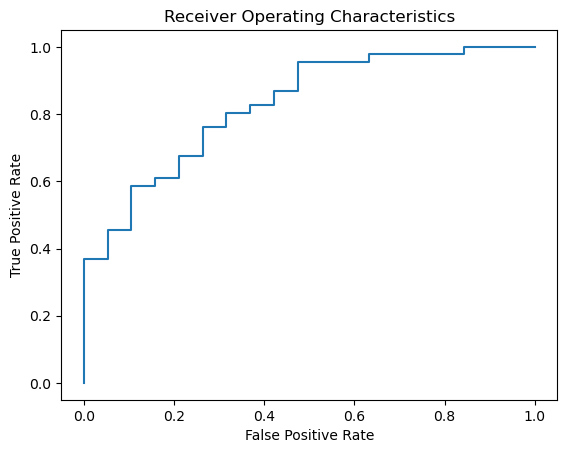

In [20]:
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

# Tune Batch Size and # Epochs

In [22]:
# We will try to tune hyperparameters with the Deep Simple Model


# create model with skorch
model = NeuralNetClassifier(
    DeepSimple,
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    verbose=False
)

# define the grid search parameters
param_grid = {
    'batch_size': [10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 50, 100, 300]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
 
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.869849 using {'batch_size': 10, 'max_epochs': 300}
0.735198 (0.050749) with: {'batch_size': 10, 'max_epochs': 10}
0.851069 (0.014201) with: {'batch_size': 10, 'max_epochs': 50}
0.837180 (0.017565) with: {'batch_size': 10, 'max_epochs': 100}
0.869849 (0.012357) with: {'batch_size': 10, 'max_epochs': 300}
0.748891 (0.010013) with: {'batch_size': 20, 'max_epochs': 10}
0.827921 (0.006070) with: {'batch_size': 20, 'max_epochs': 50}
0.846635 (0.021966) with: {'batch_size': 20, 'max_epochs': 100}
0.837180 (0.007165) with: {'batch_size': 20, 'max_epochs': 300}
0.790558 (0.031052) with: {'batch_size': 40, 'max_epochs': 10}
0.841745 (0.018459) with: {'batch_size': 40, 'max_epochs': 50}
0.851265 (0.016541) with: {'batch_size': 40, 'max_epochs': 100}
0.823292 (0.023324) with: {'batch_size': 40, 'max_epochs': 300}
0.693075 (0.009712) with: {'batch_size': 60, 'max_epochs': 10}
0.851265 (0.016541) with: {'batch_size': 60, 'max_epochs': 50}
0.855895 (0.025784) with: {'batch_size': 60, 'max_epo

# Tune Training Optimization Algorithm

In [23]:
# create model with skorch
model = NeuralNetClassifier(
    DeepSimple,
    criterion=nn.BCELoss,
    max_epochs=300,
    batch_size=10,
    verbose=False
)

# define the grid search parameters
param_grid = {
    'optimizer': [optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                  optim.Adam, optim.Adamax, optim.NAdam],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
 
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855829 using {'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
0.827986 (0.016569) with: {'optimizer': <class 'torch.optim.sgd.SGD'>}
0.743936 (0.073056) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}
0.855829 (0.006138) with: {'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
0.702269 (0.014218) with: {'optimizer': <class 'torch.optim.adadelta.Adadelta'>}
0.841875 (0.039755) with: {'optimizer': <class 'torch.optim.adam.Adam'>}
0.804643 (0.022717) with: {'optimizer': <class 'torch.optim.adamax.Adamax'>}
0.818727 (0.021808) with: {'optimizer': <class 'torch.optim.nadam.NAdam'>}


# Tune # of Neurons in Hidden Layers

In [26]:
# create model with skorch
model = NeuralNetClassifier(
    DeepSimple,
    criterion=nn.BCELoss,
    optimizer=optim.Adagrad,
    max_epochs=300,
    batch_size=10,
    verbose=False
)
 
# define the grid search parameters
param_grid = {
    'module__n_neurons': [4, 8, 16, 32, 64, 128]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)
 
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.846766 using {'module__n_neurons': 32}
0.655516 (0.045586) with: {'module__n_neurons': 4}
0.799948 (0.013838) with: {'module__n_neurons': 8}
0.837311 (0.016454) with: {'module__n_neurons': 16}
0.846766 (0.040268) with: {'module__n_neurons': 32}
0.842071 (0.033949) with: {'module__n_neurons': 64}
0.827921 (0.006070) with: {'module__n_neurons': 128}


# Final Model

In [32]:
model = DeepSimple(n_neurons=32)
acc = model_train(model, X_train, y_train, X_test, y_test, optimizer=optim.Adagrad(model.parameters()), n_epochs=300, batch_size=10)
print(f"Final model accuracy: {acc*100:.2f}%")
 
model.eval()

Final model accuracy: 84.62%


DeepSimple(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=32, out_features=32, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

[ 0.   67.    1.   70.    1.   65.    0.   88.    0.   71.96  0.    1.
  0.    0.    1.    0.  ] -> [0.00576953] (expected [0.])
[ 0.   79.    1.   76.    1.   65.6   0.   58.    0.   55.47  0.    0.
  1.    0.    0.    1.  ] -> [0.99708146] (expected [1.])
[ 0.   84.    0.   75.    0.   69.    1.   62.    0.   62.36  0.    0.
  1.    0.    0.    1.  ] -> [0.9989717] (expected [1.])
[ 0.   48.    1.   51.    1.   58.    1.   60.    0.   58.79  0.    1.
  0.    1.    0.    0.  ] -> [0.025121] (expected [0.])
[ 1.   80.    0.   80.    0.   72.    1.   63.79  1.   66.04  0.    1.
  0.    1.    0.    0.  ] -> [0.9976769] (expected [1.])


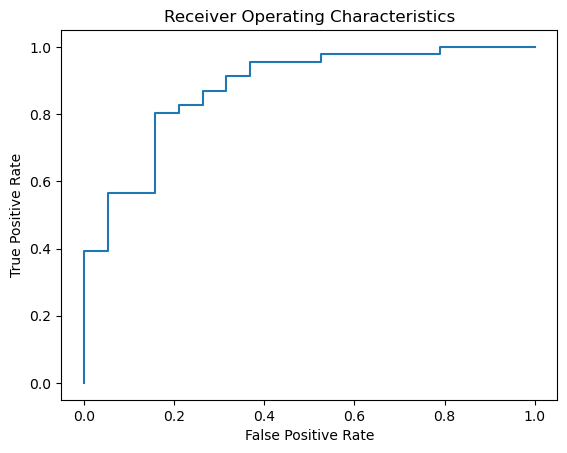

In [33]:
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()